In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [ ]:

import subprocess, sys

def sh(cmd):
    print(f"\n$ {cmd}")
    subprocess.call(cmd, shell=True)

print("== 1) GPU check ==")
sh("nvidia-smi || true")   

print("\n== 2) Python & torch check ==")
try:
    import torch
    print("torch:", torch.__version__, "cuda_available:", torch.cuda.is_available())
except Exception as e:
    print("torch import failed:", e)
    print("Installing torch (this may take a few minutes)...")
    sh("pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118")

print("\n== 3) transformers / datasets check ==")
try:
    import transformers, datasets
    print("transformers:", transformers.__version__, "datasets:", datasets.__version__)
except Exception as e:
    print("transformers/datasets import failed:", e)
    print("Installing transformers, datasets, accelerate, tokenizers, sentencepiece...")
    sh("pip install -q transformers datasets accelerate evaluate sentencepiece tokenizers")

print("\n== 4) optional extras ==")
sh("pip install -q wandb")
print('\nDone. If installs ran, rerun this cell once to confirm imports.')


== 1) GPU check ==

$ nvidia-smi || true
Thu Sep 11 17:43:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------

In [5]:
# Quick imports & random seed
import random, numpy as np, torch
print("numpy", np.__version__)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
print("Seed set. torch.cuda_available =", torch.cuda.is_available())


numpy 1.26.4
Seed set. torch.cuda_available = True


In [6]:
import pandas as pd

path = "/kaggle/input/respective-questions-with-their-acts/allQuestions_augmented.csv"

df = pd.read_csv(path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample rows:")
display(df.head(10))


Shape: (3618, 2)
Columns: ['question', 'act']

Sample rows:


,question,act
0,What is the name of a medical practitioner who...,Work Injury Benefits Act
1,What kind of compensation does a widow have to...,Work Injury Benefits Act
2,"[Act No. 8 of 1991, s. 59, Act No. 9 of 1992, ...",Income Tax Act
3,What is the purpose of the testimony of a witn...,Evidence Act
4,What does the Commissioner do for the purposes...,Tax Procedures Act
5,What is the name of the company that made the ...,Evidence Act
6,What kind of damages are claimed in suits in w...,Evidence Act
7,"- ""What is the legal underpinning of the Sale ...",Law of Contract Act
8,What is the name of the legal entity that is a...,Income Tax Act
9,"What is the name of a person who, by this sect...",Marriage Act


In [7]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer


TEXT_COL = "question"     
LABEL_COL = "act"     

train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

print(dataset)

model_path = "/kaggle/input/roberta-classifier-model/roberta_classifier_augmented"  
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize(batch):
    return tokenizer(batch[TEXT_COL], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)
print(tokenized_dataset)


DatasetDict({
    train: Dataset({
        features: ['question', 'act', '__index_level_0__'],
        num_rows: 2894
    })
    test: Dataset({
        features: ['question', 'act', '__index_level_0__'],
        num_rows: 724
    })
})


Map:   0%|          | 0/2894 [00:00<?, ? examples/s]

Map:   0%|          | 0/724 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'act', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 2894
    })
    test: Dataset({
        features: ['question', 'act', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 724
    })
})


In [9]:
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == 

In [10]:
import evaluate

print("evaluate version:", evaluate.__version__)

2025-09-11 17:44:50.854018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757612691.177272      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757612691.266127      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


evaluate version: 0.4.5


In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate


model_path = "/kaggle/input/roberta-classifier-model/roberta_classifier_augmented"   

labels = sorted(df[LABEL_COL].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
print("Labels:", labels)
print("label2id:", label2id)

def encode_labels(batch):
    batch["labels"] = label2id[batch[LABEL_COL]]
    return batch

encoded_dataset = tokenized_dataset.map(encode_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)




Labels: ['Constitution of Kenya', 'Data Protection Act', 'Distress for Rent Act', 'Employment Act', 'Evidence Act', 'Excise Duty Act', 'Fatal Accidents Act', 'Income Tax Act', 'Labour Relations Act', 'Land Act', 'Law of Contract Act', 'Law of Succession Act', 'Marriage Act', 'Persons with Disabilities Act', 'Small Claims Court Act', 'Tax Procedures Act', 'Value Added Tax Act', 'Work Injury Benefits Act']
label2id: {'Constitution of Kenya': 0, 'Data Protection Act': 1, 'Distress for Rent Act': 2, 'Employment Act': 3, 'Evidence Act': 4, 'Excise Duty Act': 5, 'Fatal Accidents Act': 6, 'Income Tax Act': 7, 'Labour Relations Act': 8, 'Land Act': 9, 'Law of Contract Act': 10, 'Law of Succession Act': 11, 'Marriage Act': 12, 'Persons with Disabilities Act': 13, 'Small Claims Court Act': 14, 'Tax Procedures Act': 15, 'Value Added Tax Act': 16, 'Work Injury Benefits Act': 17}


Map:   0%|          | 0/2894 [00:00<?, ? examples/s]

Map:   0%|          | 0/724 [00:00<?, ? examples/s]

In [13]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,          
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    report_to=["none"],              
    disable_tqdm=False
)

In [14]:


accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1_score = f1.compute(predictions=preds, references=labels, average="weighted")
    return {**acc, **f1_score}

print("Model + Trainer setup ready ")

Model + Trainer setup ready 


In [15]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())


GPU available: True
Current device: 0


In [16]:
from transformers import TrainerCallback

class EpochPrinterCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"\n===== Starting Epoch {state.epoch:.0f}/{args.num_train_epochs} =====")


early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping, EpochPrinterCallback()]
)

trainer.train()


/tmp/ipykernel_36/2719351792.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



===== Starting Epoch 0/5 =====


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.685600,0.527437,0.872928,0.873626
2,0.323900,0.411860,0.897790,0.897600
3,0.222300,0.373668,0.908840,0.909040
4,0.206100,0.394625,0.906077,0.906179
5,0.148700,0.393081,0.907459,0.907228



===== Starting Epoch 1/5 =====


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



===== Starting Epoch 2/5 =====


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



===== Starting Epoch 3/5 =====


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



===== Starting Epoch 4/5 =====


TrainOutput(global_step=455, training_loss=0.5735903711109371, metrics={'train_runtime': 843.1412, 'train_samples_per_second': 17.162, 'train_steps_per_second': 0.54, 'total_flos': 3807763906498560.0, 'train_loss': 0.5735903711109371, 'epoch': 5.0})

In [18]:
import torch
import torch.nn.functional as F

def predict_query(query, top_k=1):
    # Tokenize the query
    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True).to(model.device)
    
    # Get logits
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Convert to probabilities
    probs = F.softmax(logits, dim=-1)
    
    # Top prediction(s)
    top_probs, top_indices = torch.topk(probs, k=top_k, dim=-1)
    
    for i in range(top_k):
        pred_label = id2label[top_indices[0, i].item()]
        pred_prob = top_probs[0, i].item() * 100
        print(f"Query: {query}")
        print(f"Predicted Act: {pred_label} ({pred_prob:.2f}%)\n")

# === Examples ===
sample_queries = [
    "What is the process for filing a small claims case?",
    "How is income tax calculated in Kenya?",
    "Who is eligible under the Persons with Disabilities Act?",
    "What are the conditions for marriage registration?",
    "What remedies exist for fatal accidents?"
]

for q in sample_queries:
    predict_query(q)


Query: What is the process for filing a small claims case?
Predicted Act: Small Claims Court Act (95.24%)

Query: How is income tax calculated in Kenya?
Predicted Act: Income Tax Act (98.09%)

Query: Who is eligible under the Persons with Disabilities Act?
Predicted Act: Persons with Disabilities Act (97.69%)

Query: What are the conditions for marriage registration?
Predicted Act: Marriage Act (98.39%)

Query: What remedies exist for fatal accidents?
Predicted Act: Fatal Accidents Act (94.80%)



In [19]:
ambiguous_queries = [
    "Can a company terminate an employee without notice?",
    "How do I recover rent if the tenant refuses to pay?",
    "Who inherits property when someone dies without a will?",
    "What happens if someone is injured at work?",
    "How do I file a complaint about misuse of personal data?",
    "What are the rules for taxing imported goods?",
    "How can disputes over land boundaries be resolved?",
    "What is required to legally get married?",
    "Who is responsible for compensating a deceased person's family?",
    "When can a small claims case be appealed?"
]

for q in ambiguous_queries:
    predict_query(q)


Query: Can a company terminate an employee without notice?
Predicted Act: Employment Act (93.91%)

Query: How do I recover rent if the tenant refuses to pay?
Predicted Act: Distress for Rent Act (50.27%)

Query: Who inherits property when someone dies without a will?
Predicted Act: Law of Succession Act (97.39%)

Query: What happens if someone is injured at work?
Predicted Act: Work Injury Benefits Act (96.25%)

Query: How do I file a complaint about misuse of personal data?
Predicted Act: Data Protection Act (98.13%)

Query: What are the rules for taxing imported goods?
Predicted Act: Value Added Tax Act (86.19%)

Query: How can disputes over land boundaries be resolved?
Predicted Act: Land Act (95.39%)

Query: What is required to legally get married?
Predicted Act: Marriage Act (98.06%)

Query: Who is responsible for compensating a deceased person's family?
Predicted Act: Work Injury Benefits Act (33.81%)

Query: When can a small claims case be appealed?
Predicted Act: Small Claims C

In [21]:
ambiguous_queries = [
    "Can I get compensation if I am hurt at work?",
    "How do I challenge a tax assessment?",
    "Who inherits if someone dies intestate?",
    "How can I recover unpaid rent from a tenant?",
    "What are the requirements for legally marrying abroad?",
    "How do I report misuse of my personal data?",
    "What is the process for filing a small claims case?",
    "Are there limits on employment termination without notice?",
    "What are the rules for VAT on imported goods?",
    "How to handle disputes over land ownership?"
]


for q in ambiguous_queries:
    predict_query(q)

Query: Can I get compensation if I am hurt at work?
Predicted Act: Work Injury Benefits Act (90.36%)

Query: How do I challenge a tax assessment?
Predicted Act: Tax Procedures Act (97.22%)

Query: Who inherits if someone dies intestate?
Predicted Act: Law of Succession Act (97.25%)

Query: How can I recover unpaid rent from a tenant?
Predicted Act: Employment Act (48.23%)

Query: What are the requirements for legally marrying abroad?
Predicted Act: Marriage Act (98.36%)

Query: How do I report misuse of my personal data?
Predicted Act: Data Protection Act (98.17%)

Query: What is the process for filing a small claims case?
Predicted Act: Small Claims Court Act (95.24%)

Query: Are there limits on employment termination without notice?
Predicted Act: Employment Act (97.90%)

Query: What are the rules for VAT on imported goods?
Predicted Act: Value Added Tax Act (58.85%)

Query: How to handle disputes over land ownership?
Predicted Act: Land Act (87.88%)



In [27]:
def predict_query_top3(query, top_k=3):
   
    inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True).to(model.device)
    
   
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    

    probs = F.softmax(logits, dim=-1)
    
   
    top_probs, top_indices = torch.topk(probs, k=top_k, dim=-1)
    
    print(f"\nQuery: {query}")
    for i in range(top_k):
        pred_label = id2label[top_indices[0, i].item()]
        pred_prob = top_probs[0, i].item() * 100
        print(f"  Top {i+1}: {pred_label} ({pred_prob:.2f}%)")



In [28]:
more_ambiguous_queries = [
    "Who is responsible if someone dies due to an accident at work or elsewhere?",
    "Can I get back taxes I mistakenly paid, or am I fined instead?",
    "What legal options exist if someone refuses to follow a contract?",
    "How is personal data handled when shared with multiple organizations?",
    "Can a landlord seize property if rent is unpaid but there’s a dispute?",
    "What benefits can someone claim if injured while working for different employers?",
    "How do inheritance rights apply when there’s a dispute between family members?",
    "Are there special rules for marriage when one person has disabilities?",
    "What procedures are followed for small claims cases that involve employment disputes?",
    "How do VAT and Excise Duty affect imported goods for businesses?"
]

for q in more_ambiguous_queries:
    predict_query_top3(q)



Query: Who is responsible if someone dies due to an accident at work or elsewhere?
  Top 1: Work Injury Benefits Act (96.30%)
  Top 2: Fatal Accidents Act (1.46%)
  Top 3: Constitution of Kenya (0.44%)

Query: Can I get back taxes I mistakenly paid, or am I fined instead?
  Top 1: Tax Procedures Act (97.92%)
  Top 2: Persons with Disabilities Act (0.77%)
  Top 3: Excise Duty Act (0.37%)

Query: What legal options exist if someone refuses to follow a contract?
  Top 1: Law of Contract Act (93.24%)
  Top 2: Constitution of Kenya (1.86%)
  Top 3: Labour Relations Act (0.64%)

Query: How is personal data handled when shared with multiple organizations?
  Top 1: Data Protection Act (97.50%)
  Top 2: Tax Procedures Act (0.73%)
  Top 3: Persons with Disabilities Act (0.32%)

Query: Can a landlord seize property if rent is unpaid but there’s a dispute?
  Top 1: Distress for Rent Act (68.05%)
  Top 2: Employment Act (16.17%)
  Top 3: Marriage Act (2.36%)

Query: What benefits can someone claim

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


<Figure size 1200x1200 with 0 Axes>

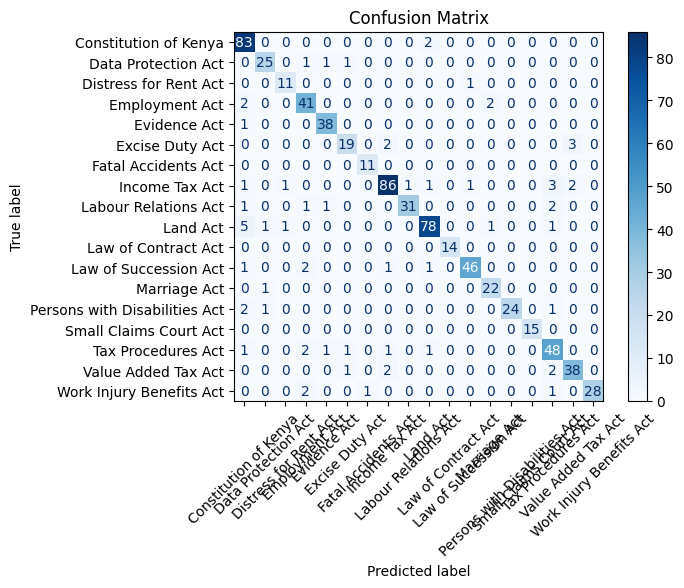

Classification Report:

                               precision    recall  f1-score   support

        Constitution of Kenya       0.86      0.98      0.91        85
          Data Protection Act       0.89      0.89      0.89        28
        Distress for Rent Act       0.85      0.92      0.88        12
               Employment Act       0.84      0.91      0.87        45
                 Evidence Act       0.93      0.97      0.95        39
              Excise Duty Act       0.86      0.79      0.83        24
          Fatal Accidents Act       0.92      1.00      0.96        11
               Income Tax Act       0.93      0.90      0.91        96
         Labour Relations Act       0.97      0.86      0.91        36
                     Land Act       0.94      0.90      0.92        87
          Law of Contract Act       1.00      1.00      1.00        14
        Law of Succession Act       0.96      0.90      0.93        51
                 Marriage Act       0.88      0.96  

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np


preds_output = trainer.predict(encoded_dataset["test"])
logits = preds_output.predictions
labels_true = preds_output.label_ids

preds = np.argmax(logits, axis=-1)


cm = confusion_matrix(labels_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(12,12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


print("Classification Report:\n")
print(classification_report(labels_true, preds, target_names=labels))


In [31]:
save_path = "./roberta_classifier_retrained"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to {save_path}")


Model and tokenizer saved to ./roberta_classifier_retrained


In [33]:
!zip -r roberta_classifier_retrained.zip roberta_classifier_retrained


updating: roberta_classifier_retrained/ (stored 0%)
updating: roberta_classifier_retrained/merges.txt (deflated 53%)
updating: roberta_classifier_retrained/tokenizer.json (deflated 82%)
updating: roberta_classifier_retrained/model.safetensors (deflated 14%)
updating: roberta_classifier_retrained/training_args.bin (deflated 52%)
updating: roberta_classifier_retrained/config.json (deflated 61%)
updating: roberta_classifier_retrained/tokenizer_config.json (deflated 75%)
updating: roberta_classifier_retrained/special_tokens_map.json (deflated 84%)
updating: roberta_classifier_retrained/vocab.json (deflated 59%)


In [34]:
!mv roberta_classifier_retrained.zip /kaggle/working/

mv: 'roberta_classifier_retrained.zip' and '/kaggle/working/roberta_classifier_retrained.zip' are the same file
